Import dependencies and install dependencies


In [1]:
!pip install datasets pandas openai rouge_score tqdm matplotlib numpy seaborn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from datasets import load_dataset
import pandas as pd
ds = load_dataset("StonyBrookNLP/tellmewhy")
print(ds)

C:\Users\theja\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['narrative', 'question', 'original_sentence_for_question', 'narrative_lexical_overlap', 'is_ques_answerable', 'answer', 'is_ques_answerable_annotator', 'original_narrative_form', 'question_meta', 'helpful_sentences', 'human_eval', 'val_ann', 'gram_ann'],
        num_rows: 71892
    })
    validation: Dataset({
        features: ['narrative', 'question', 'original_sentence_for_question', 'narrative_lexical_overlap', 'is_ques_answerable', 'answer', 'is_ques_answerable_annotator', 'original_narrative_form', 'question_meta', 'helpful_sentences', 'human_eval', 'val_ann', 'gram_ann'],
        num_rows: 8976
    })
    test: Dataset({
        features: ['narrative', 'question', 'original_sentence_for_question', 'narrative_lexical_overlap', 'is_ques_answerable', 'answer', 'is_ques_answerable_annotator', 'original_narrative_form', 'question_meta', 'helpful_sentences', 'human_eval', 'val_ann', 'gram_ann'],
        num_rows: 10689
    })
})


In [39]:
# Convert each split to pandas DataFrame with all columns
train_df = pd.DataFrame(ds['train'])
valid_df = pd.DataFrame(ds['validation'])
test_df = pd.DataFrame(ds['test'])

# Let's see what we have
print("Columns in training set:", train_df.columns.tolist())
print("\nSample row:")
print("\nNarrative:", train_df['narrative'].iloc[0])
print("\nQuestion:", train_df['question'].iloc[0])
print("\nAnswer:", train_df['answer'].iloc[0])

Columns in training set: ['narrative', 'question', 'original_sentence_for_question', 'narrative_lexical_overlap', 'is_ques_answerable', 'answer', 'is_ques_answerable_annotator', 'original_narrative_form', 'question_meta', 'helpful_sentences', 'human_eval', 'val_ann', 'gram_ann']

Sample row:

Narrative: Cam ordered a pizza and took it home. He opened the box to take out a slice. Cam discovered that the store did not cut the pizza for him. He looked for his pizza cutter but did not find it. He had to use his chef knife to cut a slice.

Question: Why did Cam order a pizza?

Answer: Cam was hungry.


This cell prepares training data for regular fine tuning based on the data set given. OPenai requires file type to be jsonl

In [ ]:
import json

def prepare_training_data(df):
    training_data = []
    for _, row in df.iterrows():
        # Format each conversation turn
        conversation = {
            "messages": [
                {"role": "system", "content": "You are a helpful assistant that explains why events happen in stories."},
                {"role": "user", "content": f"Story: {row['narrative']}\nQuestion: {row['question']}"},
                {"role": "assistant", "content": f"{row['answer']}"}
            ]
        }
        training_data.append(conversation)
    return training_data

# Convert training data and grabbing first 1000 samples (i dont want to go broke)
training_data = prepare_training_data(train_df)[:1000]

# Save as JSONL file
with open('tellmewhy_training.jsonl1', 'w') as f:
    for entry in training_data:
        f.write(json.dumps(entry) + '\n')

In [ ]:
#test api key
from openai import OpenAI
import requests
from apikeyfile import openai_apikey

APIKEY = openai_apikey()
client = OpenAI(api_key=APIKEY)



The cell below creates a file ID to send to openai so it can fine tune based on the file with adjusted hyperparams

In [ ]:
#fine tune model
#FINISHED FINE TUNING
PATH = "./tellmewhy_training.jsonl1"
MODEL = "gpt-3.5-turbo"
#upload training file
def fine_tune_model(path, model):
    file = client.files.create(
        file=open(path, "rb"),
        purpose="fine-tune"
    )
    print(f"File ID: {file.id}")

    job = client.fine_tuning.jobs.create(
        training_file=file.id,
        model=model,
        hyperparameters={
            "n_epochs": 2
        }
    )
    return job

The cell below is for evaluation of basic fine tuning with just the data set.

In [53]:
from openai import OpenAI
from rouge_score import rouge_scorer
import pandas as pd
from tqdm import tqdm

client = OpenAI(api_key=APIKEY)

def evaluate_model(model_id, test_df, num_samples=50):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])
    results = []
    
    # Sample from test set
    test_sample = test_df.sample(n=num_samples) if num_samples else test_df
    
    for _, row in tqdm(test_sample.iterrows(), total=len(test_sample)):
        try:
            # Get model prediction
            response = client.chat.completions.create(
                model=model_id,
                messages=[
                    {"role": "system", "content": "You are a helpful assistant that explains why events happen in stories."},
                    {"role": "user", "content": f"Story: {row['narrative']}\nQuestion: {row['question']}"}
                ]
            )
            predicted = response.choices[0].message.content
            actual = row['answer']
            
            # Calculate ROUGE scores
            scores = scorer.score(actual, predicted)
            
            results.append({
                'story': row['narrative'],
                'question': row['question'],
                'actual': actual,
                'predicted': predicted,
                'rouge1': scores['rouge1'].fmeasure,
                'rouge2': scores['rouge2'].fmeasure,
                'rougeL': scores['rougeL'].fmeasure
            })
        except Exception as e:
            print(f"Error processing example: {e}")
            
    return pd.DataFrame(results)

# Just use the base model and your final fine-tuned model
models = {
    'Base Model': 'gpt-3.5-turbo',
    'Fine-tuned Model': 'ft:gpt-3.5-turbo-0125:personal::AaJ540hL'  # Your final model ID
}

# Run evaluation
results = {}
for name, model_id in models.items():
    print(f"\nEvaluating {name}...")
    eval_df = evaluate_model(model_id, test_df, num_samples=50)
    
    if not eval_df.empty:  # Check if we got results
        # Calculate average metrics
        avg_metrics = {
            'rouge1': eval_df['rouge1'].mean(),
            'rouge2': eval_df['rouge2'].mean(),
            'rougeL': eval_df['rougeL'].mean()
        }
        results[name] = avg_metrics

# Create comparison table
if results:  # Only if we have results
    comparison_df = pd.DataFrame(results).T
    print("\nModel Comparison:")
    print(comparison_df)


Evaluating Base Model...


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]



Evaluating Fine-tuned Model...


100%|██████████| 50/50 [01:50<00:00,  2.22s/it]


Model Comparison:
                    rouge1    rouge2    rougeL
Base Model        0.138465  0.048654  0.119029
Fine-tuned Model  0.225448  0.076333  0.205592


In [ ]:
import json
#preparing data set 

Cell block below visualizes the evaluation metrics

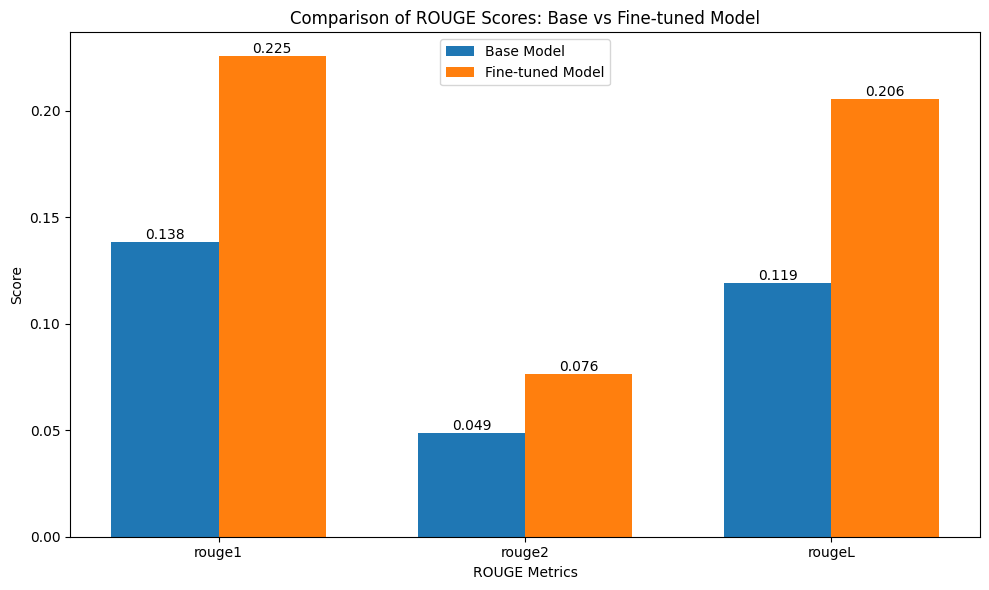

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_rouge_comparison():
    # Your results from the evaluation
    results = {
        'Base Model': {
            'rouge1': 0.138465,
            'rouge2': 0.048654,
            'rougeL': 0.119029
        },
        'Fine-tuned Model': {
            'rouge1': 0.225448,
            'rouge2': 0.076333,
            'rougeL': 0.205592
        }
    }
    
    # Prepare data for plotting
    metrics = ['rouge1', 'rouge2', 'rougeL']
    
    # Set up the plot
    plt.figure(figsize=(10, 6))
    x = np.arange(len(metrics))
    width = 0.35
    
    # Create bars
    plt.bar(x - width/2, [results['Base Model'][m] for m in metrics], width, label='Base Model')
    plt.bar(x + width/2, [results['Fine-tuned Model'][m] for m in metrics], width, label='Fine-tuned Model')
    
    # Customize plot
    plt.xlabel('ROUGE Metrics')
    plt.ylabel('Score')
    plt.title('Comparison of ROUGE Scores: Base vs Fine-tuned Model')
    plt.xticks(x, metrics)
    plt.legend()
    
    # Add value labels on bars
    for i in x:
        plt.text(i - width/2, results['Base Model'][metrics[i]], 
                f'{results["Base Model"][metrics[i]]:.3f}', 
                ha='center', va='bottom')
        plt.text(i + width/2, results['Fine-tuned Model'][metrics[i]], 
                f'{results["Fine-tuned Model"][metrics[i]]:.3f}', 
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

plot_rouge_comparison()

Cell below prepares data to be fine tuned with chain of thought prompting implemented

In [ ]:

def prepare_training_data_COT(df: pd.DataFrame, num: int):
    """
    This prepares training data to be sent to the chatgpt openai api\n
    df is the dataframe\n
    num is the amount of rows you want to sample
    """
    training_data = []
    #basically grabs num//2 random samples of answerable and unanswerable questions then concats them
    answerable = df[df['is_ques_answerable']=='Answerable'].sample(n=num//2)
    not_answerable = df[df['is_ques_answerable']== 'Not Answerable'].sample(n=num//2)

    df_subset = pd.concat([answerable, not_answerable])
    #grabs index, and row so we ignore the index and only grab the row
    for _, row in df_subset.iterrows():
        system_content = """
        You are a helpful assistant trained to analyze stories and answer 'why' questions. Your goal is to explain the motivations behind events in the story by reasoning step-by-step about the context and actions described.
        """

        user_content = f""" 
        Story: {row['narrative']}\n
        To answer the question, follow these steps:
        1. Summarize the key events in the story relevant to the question.
        2. Identify any actions, decisions, or events tied to the question.
        3. Think about the characters' motivations, goals, or circumstances that might explain why these actions or events occurred.
        4. Combine these insights to form a clear and logical explanation.
        \nQuestion: {row['question']}
"""

        conversation = {
            "messages": [
                {"role": "system", "content": system_content},
                {"role": "user", "content": user_content},
                {"role": "assistant", "content": f"{row['answer']}"}
            ]
        }
        training_data.append(conversation)
    
    #create new file and writes to file
    with open("tellmewhy_training_iti_2.jsonl", "w") as f:
        for entry in training_data:
            f.write(json.dumps(entry)+ '\n')
        

prepare_training_data_COT(train_df, 50)


    

Cell below initiates the fine tuning via api call

In [61]:
PATH = "./tellmewhy_training_iti_2.jsonl"
MODEL = "gpt-3.5-turbo"

job = fine_tune_model(path=PATH, model=MODEL)

File ID: file-UGZFGr6ubJLXVd2ycaxYUx


Cell block below evaluates the models by taking stories and questions, sending them to different language models, and comparing the predicted answers to the reference answers. For evaluation, it calculates three different ROUGE metrics: ROUGE-1, which measures overlap of individual words; ROUGE-2, which measures overlap of word pairs (bigrams); and ROUGE-L, which measures longest common subsequences. The function returns two types of results as DataFrames. The first is a summary DataFrame showing the average ROUGE scores for each model side by side, making it easy to compare model performance. The second is a detailed DataFrame containing all individual predictions and their ROUGE scores for each story-question pair, providing access to detailed results for deeper analysis.

In [69]:
from typing import Dict

def evaluate_models(client, test_df, models: Dict[str, str], num_samples: int = 50):
    """
    Evaluate multiple models and return their metrics side by side
    
    Args:
        client: OpenAI client instance
        test_df: DataFrame with test data
        models: Dictionary of model names and their IDs
        num_samples: Number of samples to evaluate
    """
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])
    all_results = []
    
    # Sample from test set
    test_sample = test_df.sample(n=num_samples, random_state=42) if num_samples else test_df
    
    for _, row in tqdm(test_sample.iterrows(), total=len(test_sample)):
        result_row = {
            'story': row['narrative'],
            'question': row['question'],
            'actual': row['answer']
        }
        
        # Get predictions from each model
        for model_name, model_id in models.items():
            try:
                response = client.chat.completions.create(
                    model=model_id,
                    messages=[
                        {"role": "user", "content": f"Story: {row['narrative']}\nQuestion: {row['question']}"}
                    ]
                )
                predicted = response.choices[0].message.content
                
                # Calculate ROUGE scores
                scores = scorer.score(row['answer'], predicted)
                
                # Add model-specific results
                result_row.update({
                    f'{model_name}_prediction': predicted,
                    f'{model_name}_rouge1': scores['rouge1'].fmeasure,
                    f'{model_name}_rouge2': scores['rouge2'].fmeasure,
                    f'{model_name}_rougeL': scores['rougeL'].fmeasure
                })
                
            except Exception as e:
                print(f"Error with {model_name} on example: {e}")
                # Fill with NaN if there's an error
                result_row.update({
                    f'{model_name}_prediction': np.nan,
                    f'{model_name}_rouge1': np.nan,
                    f'{model_name}_rouge2': np.nan,
                    f'{model_name}_rougeL': np.nan
                })
        
        all_results.append(result_row)
    
    # Create detailed DataFrame
    detailed_df = pd.DataFrame(all_results)
    
    # Create summary DataFrame with side-by-side metrics
    metrics = ['rouge1', 'rouge2', 'rougeL']
    summary_data = {}
    
    for model_name in models.keys():
        model_metrics = {
            f'{metric}': detailed_df[f'{model_name}_{metric}'].mean()
            for metric in metrics
        }
        summary_data[model_name] = model_metrics
    
    summary_df = pd.DataFrame(summary_data).round(4)
    
    return summary_df, detailed_df

In [ ]:
# Define your models
models = {
    'Base Model': 'gpt-3.5-turbo',
    'Fine-tuned Model': 'ft:gpt-3.5-turbo-0125:personal::AaXOCuBB'
}

# Run evaluation
summary_df, detailed_df = evaluate_models(
    client=client,
    test_df=test_df,
    models=models,
    num_samples=50
)

# View results
print(summary_df)


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:24<00:00,  1.69s/it]

        Base Model  Fine-tuned Model
rouge1      0.1871            0.2872
rouge2      0.0756            0.0993
rougeL      0.1615            0.2685


Cell below helps visualize the evaluation metrics

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_rouge_comparison(df, figsize=(12, 6)):
    """
    Plot ROUGE scores comparison between models.
    
    Args:
        df: pandas DataFrame with models as columns and metrics as index
        figsize: tuple of figure dimensions (width, height)
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get models and metrics from DataFrame
    models = df.columns
    metrics = df.index
    
    # Set width and positions
    x = np.arange(len(metrics))
    width = 0.35
    
    # Create bars
    rects1 = ax.bar(x - width/2, df[models[0]], width, label=models[0], color='#2878B5')
    rects2 = ax.bar(x + width/2, df[models[1]], width, label=models[1], color='#FF8C00')
    
    # Customize plot
    ax.set_xlabel('ROUGE Metrics')
    ax.set_ylabel('Score')
    ax.set_title('Comparison of ROUGE Scores: Base vs Fine-tuned Model')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    
    # Set y-axis limits
    ax.set_ylim(0, max(df.max()) * 1.2)
    
    # Add grid
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    
    # Add legend
    ax.legend()
    
    # Add value labels on bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2, height,
                   f'{height:.3f}',
                   ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Example usage:
# plot_rouge_comparison(comparison_df)

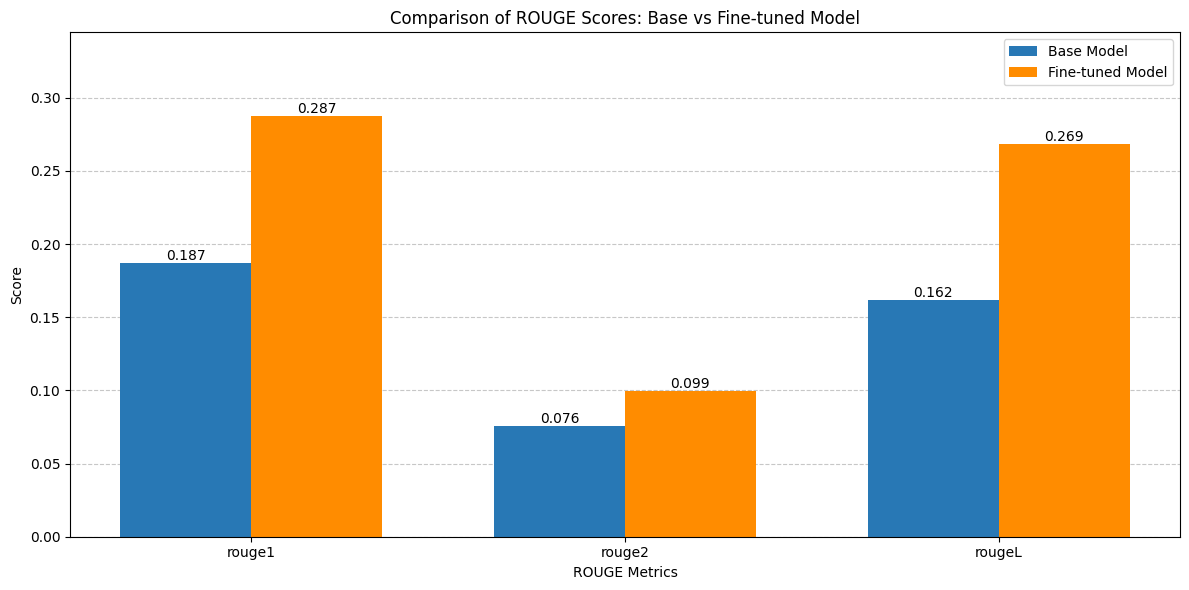

Figure(1200x600)


In [80]:
fig = plot_rouge_comparison(summary_df)
print(fig)